# Testing STFT solver implemented on STM32

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
import csv

from DSP_prototype import DSP_algorithms
import tensorflow as tf

2025-01-19 01:00:37.107509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737244837.169639    5910 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737244837.188685    5910 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 01:00:37.352915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Audio and STFT files path

In [6]:
audio_file = "../Data_acquisition/data/audio/8kHz_sampling/right_fs=8kHz_2.csv"
stft_file = "../Data_acquisition/data/stft/8kHz_sampling/stft_right_fs=8kHz_2.csv"

In [7]:
audio_data = []
with open(audio_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        audio_data.append(float(row['y']))  # Convert to int if y is numeric

audio_data = np.array(audio_data, dtype=np.float32)
print(f"Data length before resampling: {len(audio_data)}")
print(f"Data type before resampling: {type(audio_data[0])}")
display.Audio(audio_data, rate=8000, autoplay=True)

Data length before resampling: 8000
Data type before resampling: <class 'numpy.float32'>


## STFT using implemented Python solver

Number of frames: 61
signal_shape: (8000,)
STFT matrix shape: (129, 61)


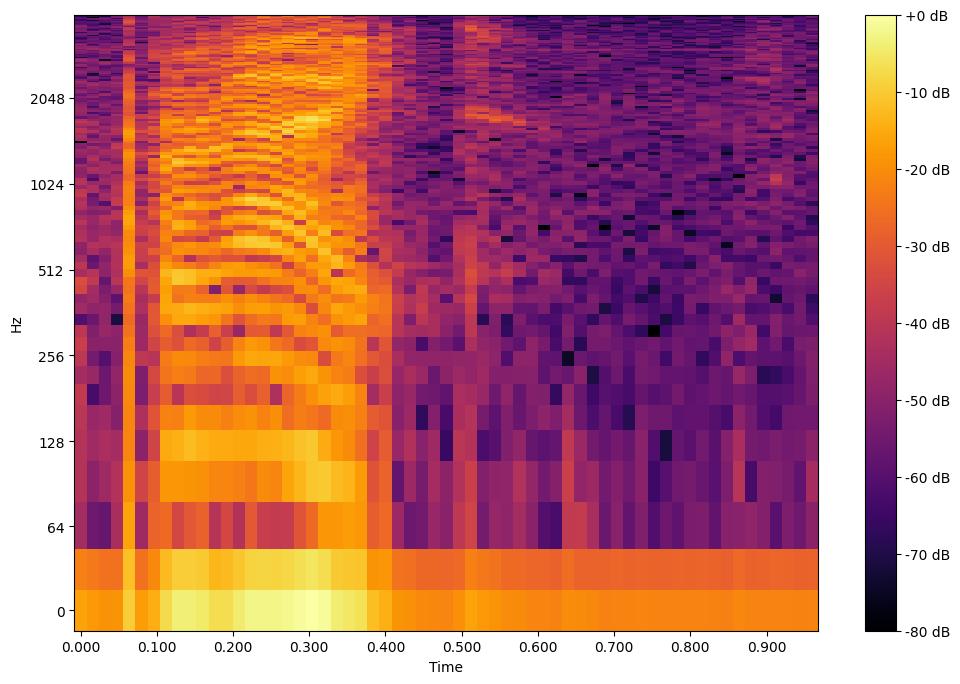

In [8]:
fs = 8e3
window_size = 256
hop_size = 128

stft_matrix, freq_bins, time_frames = DSP_algorithms.stft(audio_data, fs=fs, N=window_size, hop_size=hop_size,
                                                          window_type='hann', verbose=True)

print(f"STFT matrix shape: {stft_matrix.shape}")

S_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=fs, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [13]:
resized = tf.image.resize(abs(stft_matrix.reshape(129, 61, 1)), [32, 32])

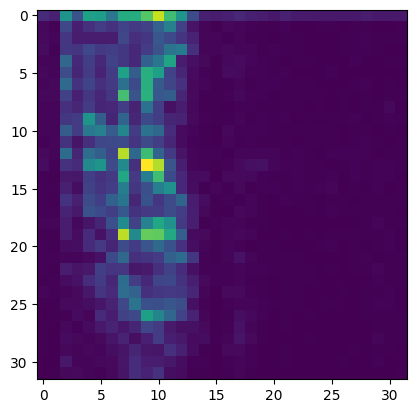

In [29]:
plt.imshow(resized, cmap="viridis")

In [30]:
def downsample_image_fixed(input_image, input_height, input_width, target_height, target_width):
    """
    Downsamples an image using bilinear interpolation, matching TensorFlow's tf.image.resize.
    """
    # Calculate scaling factors
    scale_height = input_height / target_height
    scale_width = input_width / target_width

    # Prepare the output image
    output_image = np.zeros((target_height, target_width), dtype=np.float32)

    for y in range(target_height):
        for x in range(target_width):
            # Map target pixel to source coordinates
            src_y = (y + 0.5) * scale_height - 0.5
            src_x = (x + 0.5) * scale_width - 0.5

            # Calculate integer bounding box of the source coordinates
            y0 = int(np.floor(src_y))
            x0 = int(np.floor(src_x))
            y1 = min(y0 + 1, input_height - 1)
            x1 = min(x0 + 1, input_width - 1)

            # Handle edge cases for the coordinates
            y0 = max(0, y0)
            x0 = max(0, x0)

            # Compute interpolation weights
            dy = src_y - y0
            dx = src_x - x0

            # Bilinear interpolation
            v00 = input_image[y0 * input_width + x0]
            v01 = input_image[y0 * input_width + x1]
            v10 = input_image[y1 * input_width + x0]
            v11 = input_image[y1 * input_width + x1]

            # Avoid negative weights
            value = (
                v00 * (1 - dx) * (1 - dy) +
                v01 * dx * (1 - dy) +
                v10 * (1 - dx) * dy +
                v11 * dx * dy
            )

            # Ensure no negative values (important if inputs are strictly non-negative)
            value = max(0, value)

            # Assign to the output image
            output_image[y, x] = value

    return output_image

In [51]:
def bilinear_resize(image, height, width):
  """
  `image` is a 2-D numpy array
  `height` and `width` are the desired spatial dimension of the new 2-D array.
  """
  img_height, img_width = image.shape[:2]

  resized = np.empty([height, width])

  x_ratio = float(img_width - 1) / (width - 1) if width > 1 else 0
  y_ratio = float(img_height - 1) / (height - 1) if height > 1 else 0

  for i in range(height):
    for j in range(width):

      x_l, y_l = int(np.floor(x_ratio * j)), int(np.floor(y_ratio * i))
      x_h, y_h = int(np.ceil(x_ratio * j)), int(np.ceil(y_ratio * i))

      x_weight = (x_ratio * j) - x_l
      y_weight = (y_ratio * i) - y_l

      a = image[y_l, x_l]
      b = image[y_l, x_h]
      c = image[y_h, x_l]
      d = image[y_h, x_h]

      pixel = a * (1 - x_weight) * (1 - y_weight) + b * x_weight * (1 - y_weight) + c * y_weight * (1 - x_weight) + d * x_weight * y_weight

      resized[i][j] = pixel

  return resized

In [72]:
import numpy as np

def downsample_image(input_image, input_height, input_width, target_height, target_width):
    """
    Downsamples an image using bilinear interpolation.

    Args:
        input_image (np.ndarray): Flattened 1D array representing the input image (row-major order).
        input_height (int): Height of the input image.
        input_width (int): Width of the input image.
        target_height (int): Desired height of the output image.
        target_width (int): Desired width of the output image.

    Returns:
        np.ndarray: Flattened 1D array representing the downsampled image.
    """
    # Calculate scaling factors
    scale_height = input_height / target_height
    scale_width = input_width / target_width

    # Prepare the output image
    output_image = np.zeros((target_height, target_width), dtype=np.float32)

    for y in range(target_height):
        for x in range(target_width):
            # Map target pixel to source coordinates
            src_y = y * scale_height
            src_x = x * scale_width

            y0 = int(src_y)
            x0 = int(src_x)
            y1 = min(y0 + 1, input_height - 1)
            x1 = min(x0 + 1, input_width - 1)

            # Compute interpolation weights
            dy = src_y - y0
            dx = src_x - x0

            # Bilinear interpolation
            value = (
                input_image[y0 * input_width + x0] * (1 - dx) * (1 - dy) +
                input_image[y0 * input_width + x1] * dx * (1 - dy) +
                input_image[y1 * input_width + x0] * (1 - dx) * dy +
                input_image[y1 * input_width + x1] * dx * dy
            )

            output_image[y, x] = value

    # Flatten the output image to match the input format
    return output_image.flatten()


In [52]:
stft_matrix.ndim

2

In [57]:
import PIL.Image as img

In [76]:
resized_own = downsample_image_fixed(np.abs(stft_matrix).reshape(129*61), 129, 61, 32, 32)

In [77]:
resized_own = resized_own.reshape(32, 32, 1)

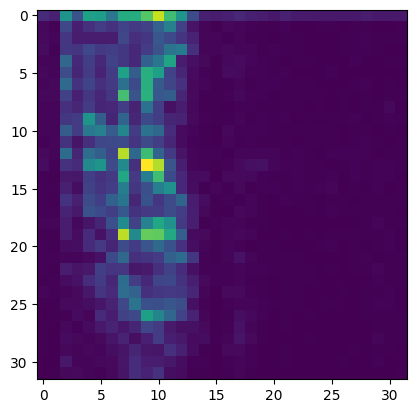

In [78]:
plt.imshow(resized_own, cmap="viridis")

## STFT using implemented STM32 solver

In [33]:
stft_data = []
with open(stft_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        stft_data.append(float(row['stft_value']))  # Convert to int if y is numeric

stft_data = np.array(stft_data, dtype=np.float32)
print(f"stft_data shape: {stft_data.shape}")

stft_data shape: (7869,)


In [17]:
np.max(stft_data)

87707.39

STFT matrix shape: (129, 61)


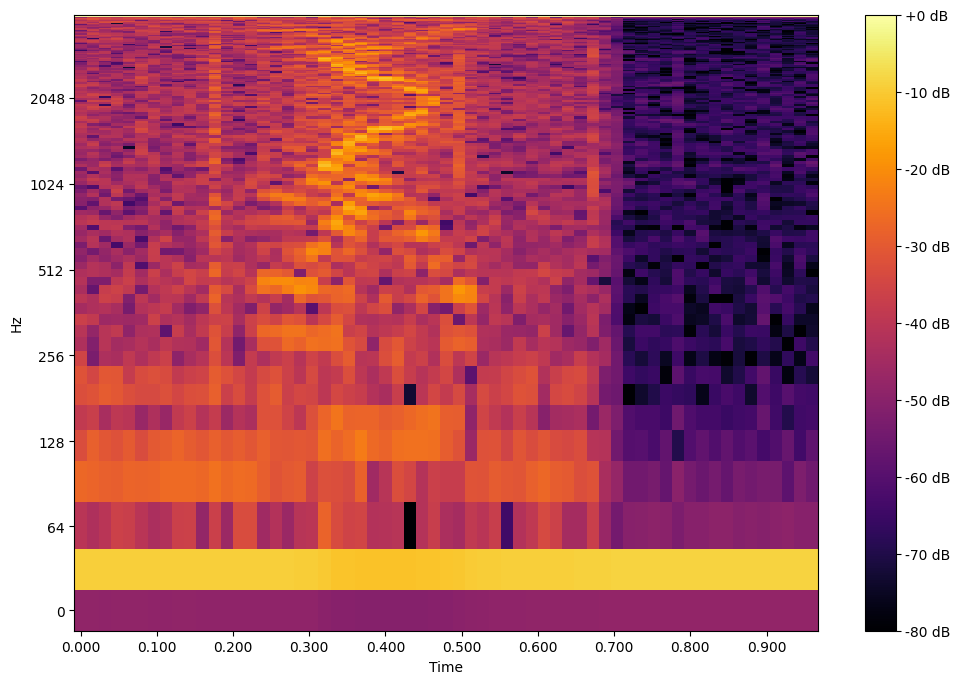

In [34]:
hop_size = 128
N = 256

num_frames = (len(stft_data) - (N // 2 + 1)) // (N // 2 + 1) + 1
frame_length = N // 2 + 1

if len(stft_data) != num_frames * frame_length:
    raise ValueError("STFT data length does not match expected frame count and frequency")

stft_matrix = np.reshape(stft_data, (frame_length, num_frames), order='F')
print(f"STFT matrix shape: {stft_matrix.shape}")

S_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=fs, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [13]:
S_db.shape

(129, 61)

STFT matrix shape: (129, 61)


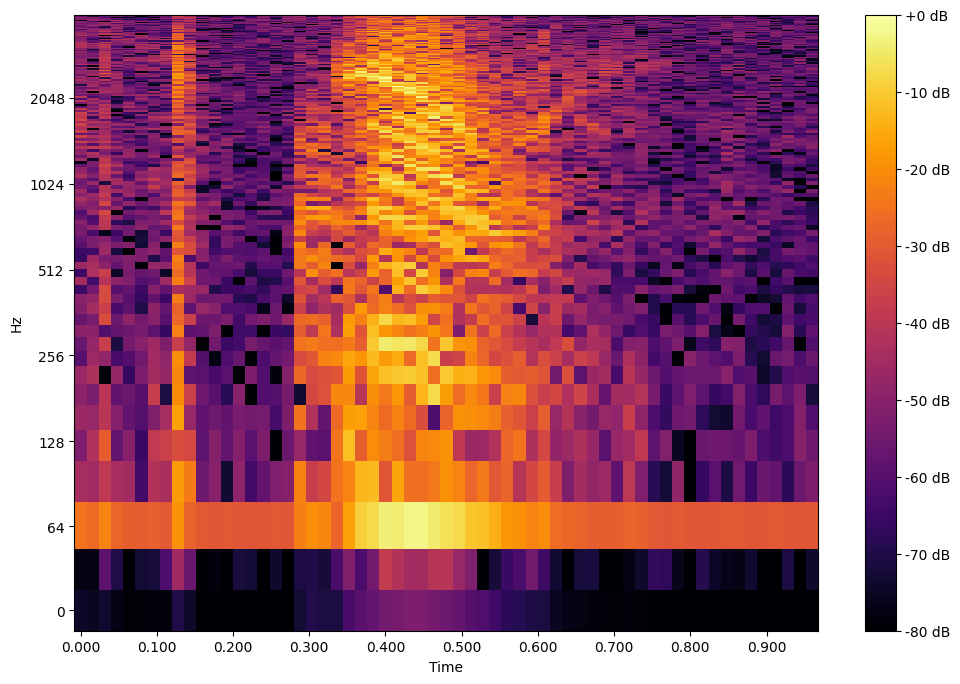

In [8]:
hop_size = 128
N = 256

num_frames = (len(stft_data) - (N // 2 + 1)) // (N // 2 + 1) + 1
frame_length = N // 2 + 1

if len(stft_data) != num_frames * frame_length:
    raise ValueError("STFT data length does not match expected frame count and frequency")

stft_matrix = np.reshape(stft_data, (frame_length, num_frames), order='F')
print(f"STFT matrix shape: {stft_matrix.shape}")

S_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=fs, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()